In [1]:
import os

import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interp
import scipy.ndimage as ndi

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

from migdalcalc import migdalcalc as mc

In [2]:
Si_migdal = mc.migdalcalc(target="Si-28", nuclear_data_name="jeff33")

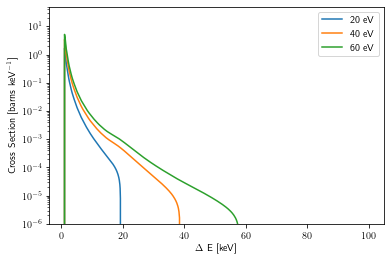

In [3]:
spec_20 = Si_migdal.dR_dDeltaE_HS(20, method='elf-ibe')
spec_40 = Si_migdal.dR_dDeltaE_HS(40, method='elf-ibe')
spec_60 = Si_migdal.dR_dDeltaE_HS(60, method='elf-ibe')

dE_range = np.geomspace(1, 100, 1000)

plt.plot(dE_range, spec_20(dE_range), label='20 eV')
plt.plot(dE_range, spec_40(dE_range), label='40 eV')
plt.plot(dE_range, spec_60(dE_range), label='60 eV')
plt.legend()
plt.xlabel(r'$\Delta$ E [keV]')
plt.ylabel(r'Cross Section [barns keV$^{-1}$]')

plt.yscale('log')
plt.ylim(1e-6, 50)
plt.show()